<a href="https://colab.research.google.com/github/Ankur099IIT/CNN-in-tensorflow--Course-2-Deeplearning.ai/blob/main/Tranfer_Learning_using_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget  --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-04-30 09:13:40--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 142.250.159.128, 74.125.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   173MB/s    in 0.5s    

2022-04-30 09:13:41 (173 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [3]:
# Initialize the base model

pre_trained_model = InceptionV3(input_shape = (150,150,3),
                                include_top = False,
                                weights = None) 

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [4]:

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [5]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [6]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [7]:
model.compile(loss = 'binary_crossentropy',
              optimizer = RMSprop(learning_rate = 0.001),
              metrics = ['accuracy'])

In [8]:
# Prepare the dataset

!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2022-04-30 09:13:58--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 209.85.146.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.3’

cats_and_dogs_filte 100%[===================>]  65.43M  59.4MB/s    in 1.1s    

2022-04-30 09:13:59 (59.4 MB/s) - ‘cats_and_dogs_filtered.zip.3’ saved [68606236/68606236]



In [9]:
import zipfile

zip_ref = zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [10]:
import os

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

cat_train_dir = os.path.join(train_dir, 'cats')
dog_train_dir = os.path.join(train_dir, 'dogs')
cat_validation_dir = os.path.join(validation_dir, 'cats')
dog_train_dir = os.path.join(validation_dir, 'dogs')

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                  )

training_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                       target_size = (150,150),
                                                       batch_size = 20,
                                                       class_mode = 'binary')

validation_datagen = ImageDataGenerator(rescale = 1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(directory = validation_dir,
                                                              target_size = (150, 150),
                                                              batch_size = 20,
                                                              class_mode = 'binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
history = model.fit(training_generator,
                    steps_per_epoch = 100,
                    epochs = 20,
                    validation_data = validation_generator,
                    validation_steps = 50,
                    verbose = 2)

Epoch 1/20
100/100 - 30s - loss: 1.2302 - accuracy: 0.8405 - val_loss: 0.2318 - val_accuracy: 0.9430 - 30s/epoch - 301ms/step
Epoch 2/20
100/100 - 24s - loss: 0.4282 - accuracy: 0.8850 - val_loss: 0.3209 - val_accuracy: 0.9230 - 24s/epoch - 236ms/step
Epoch 3/20
100/100 - 22s - loss: 0.3436 - accuracy: 0.8935 - val_loss: 0.1568 - val_accuracy: 0.9530 - 22s/epoch - 225ms/step
Epoch 4/20
100/100 - 24s - loss: 0.2878 - accuracy: 0.9085 - val_loss: 0.1168 - val_accuracy: 0.9570 - 24s/epoch - 243ms/step
Epoch 5/20
100/100 - 23s - loss: 0.2577 - accuracy: 0.9230 - val_loss: 0.1235 - val_accuracy: 0.9630 - 23s/epoch - 227ms/step
Epoch 6/20
100/100 - 23s - loss: 0.2638 - accuracy: 0.9190 - val_loss: 0.1886 - val_accuracy: 0.9510 - 23s/epoch - 231ms/step
Epoch 7/20
100/100 - 23s - loss: 0.2868 - accuracy: 0.9210 - val_loss: 0.2164 - val_accuracy: 0.9460 - 23s/epoch - 226ms/step
Epoch 8/20
100/100 - 23s - loss: 0.2700 - accuracy: 0.9255 - val_loss: 0.1434 - val_accuracy: 0.9590 - 23s/epoch - 229

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

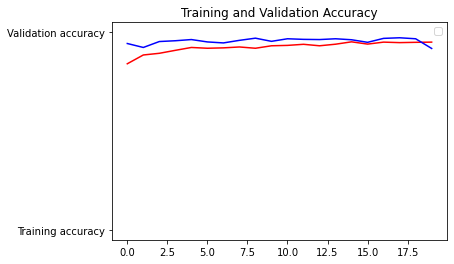

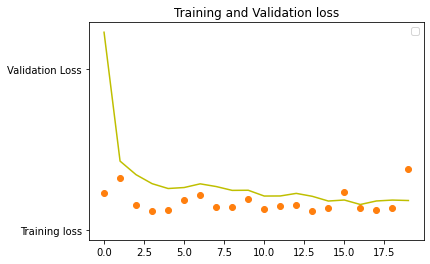

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc  =history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', 'Training accuracy'),
plt.plot(epochs, val_acc, 'b', 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc = 0)

plt.figure()

plt.plot(epochs, loss, 'y', 'Training loss')
plt.plot(epochs, val_loss, 'o', 'Validation Loss')
plt.title('Training and Validation Accuracy')
plt.title('Training and Validation loss')
plt.legend(loc = 0)

plt.figure()
